## Load Land Registry Data

In [12]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/raw_land_registry")
df = pd.read_csv(f"{DATA_DIR}/TA11.csv")

address_cols = ["paon", "saon", "street", "locality", "town", "postcode"]
df["address"] = df[address_cols].apply(
    lambda x: ";".join([str(xi) for xi in x]).replace("nan;", ""), axis=1
)

display(df.head(2))

,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,address
0,F7473CFF-4F88-4FC1-B913-4B900C3D88EB,480000,2011-05-16,TA11 6AA,D,N,F,NaN,HIGHER HURCOT HOUSE,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,HIGHER HURCOT HOUSE;HURCOT;SOMERTON;TA11 6AA
1,2333637D-2FAA-4129-9E11-002A9B01CFCF,345000,2015-01-30,TA11 6AA,T,N,F,CALF BARN,HIGHER HURCOTT FARM,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,HIGHER HURCOTT FARM;CALF BARN;HURCOT;SOMERTON;...


# Write to DB

In [ ]:
import duckdb

con = duckdb.connect("../data/main.db")


con.sql("DROP TABLE IF EXISTS properties")
con.sql("DROP SEQUENCE IF EXISTS properties_id_seq")

# Create squence & table
con.sql("CREATE SEQUENCE properties_id_seq START 1")
con.sql("""
    CREATE TABLE properties (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('properties_id_seq'),
        paon VARCHAR,
        saon VARCHAR,
        street VARCHAR,
        locality VARCHAR,
        town VARCHAR,
        postcode VARCHAR,
        district VARCHAR,
        county VARCHAR,
        address VARCHAR,
    )
""")
#†odo: ensure no duplicates

In [18]:
property_columns = address_cols + ["address", "district", "county"]
df_properties = df[property_columns].drop_duplicates().reset_index(drop=True)
df_properties["address"].nunique() == len(df_properties["address"])
print(len(df_properties["address"]))
print(df_properties["address"].nunique())
#TODO: fix the duplicate issue...


3882
3649


In [56]:
# read df into db

con.sql("""
    INSERT INTO properties (paon, saon, street, locality, town, postcode, address)
    SELECT paon, saon, street, locality, town, postcode, address FROM df_properties
""")

In [57]:
df_test = con.sql("SELECT * FROM properties").df()
display(df_test.sample(5))


,id,paon,saon,street,locality,town,postcode,address
419,420,2,None,COOMBE HILL,KEINTON MANDEVILLE,SOMERTON,TA11 6DQ,2;COOMBE HILL;KEINTON MANDEVILLE;SOMERTON;TA11...
378,379,TRINITY BARN,None,COOMBE HILL,KEINTON MANDEVILLE,SOMERTON,TA11 6DG,TRINITY BARN;COOMBE HILL;KEINTON MANDEVILLE;SO...
3617,3618,TIDDLYWINKS,None,WEST STREET,SOMERTON,SOMERTON,TA11 7PR,TIDDLYWINKS;WEST STREET;SOMERTON;SOMERTON;TA11...
289,290,15,None,CORNFLOWER CLOSE,None,SOMERTON,TA11 6BT,15;CORNFLOWER CLOSE;SOMERTON;TA11 6BT
3299,3300,43,None,None,KINGSDON,SOMERTON,TA11 7JX,43;KINGSDON;SOMERTON;TA11 7JX


## Create db for transactions

In [22]:
import duckdb

con = duckdb.connect("../data/main.db")


con.sql("DROP TABLE IF EXISTS transactions")
con.sql("DROP SEQUENCE IF EXISTS transactions_id_seq")

# Create squence & table
con.sql("CREATE SEQUENCE transactions_id_seq START 1")
con.sql("""
    CREATE TABLE transactions (
        id INTEGER PRIMARY KEY DEFAULT NEXTVAL('transactions_id_seq'),
        address VARCHAR,
        deed_date DATE,
        price_paid INTEGER,
        property_type CHAR,
        estate_type CHAR,
        new_build CHAR,
        transaction_category CHAR,
        unique_id VARCHAR
    )
""")


In [21]:
df_transactions = df[["address", "deed_date", "price_paid", "property_type", "new_build", "estate_type", "transaction_category", "unique_id"]].copy()
df_transactions["deed_date"] = pd.to_datetime(df_transactions["deed_date"])

display(df_transactions.head(2))

,address,deed_date,price_paid,property_type,new_build,estate_type,transaction_category,unique_id
0,HIGHER HURCOT HOUSE;HURCOT;SOMERTON;TA11 6AA,2011-05-16,480000,D,N,F,A,F7473CFF-4F88-4FC1-B913-4B900C3D88EB
1,HIGHER HURCOTT FARM;CALF BARN;HURCOT;SOMERTON;...,2015-01-30,345000,T,N,F,A,2333637D-2FAA-4129-9E11-002A9B01CFCF


In [9]:
print(df["property_type"].unique())
print(df["new_build"].unique())
print(df["estate_type"].unique())
print(df["transaction_category"].unique())

['D' 'T' 'S' 'O' 'F']
['N' 'Y']
['F' 'L']
['A' 'B']


In [23]:
# read df into db
con.sql("""
    INSERT INTO transactions (address, deed_date, price_paid, property_type, new_build, estate_type, transaction_category, unique_id)
    SELECT address, deed_date, price_paid, property_type, new_build, estate_type, transaction_category, unique_id FROM df_transactions
""")

In [24]:
df_test = con.sql("SELECT * FROM transactions").df()
display(df_test.sample(5))


,id,address,deed_date,price_paid,property_type,estate_type,new_build,transaction_category,unique_id
2833,2834,15;BARN CLOSE;SOMERTON;SOMERTON;TA11 6PH,2005-11-11,174000,T,F,N,A,B484F7D9-A14C-4AD2-99A7-277DCBB6590F
257,258,5;BRAMLEY ROAD;SOMERTON;TA11 6AW,2017-12-22,256995,S,F,Y,A,6B32222C-D2F5-01F1-E053-6C04A8C0D2C8
5497,5498,LYNCH COTTAGE;BEHIND BERRY;SOMERTON;SOMERTON;T...,2007-07-12,480000,D,F,N,A,3B5276FB-59E6-482F-BD26-14E69979E732
4077,4078,5;HIGHFIELD CLOSE;SOMERTON;TA11 6SZ,2021-06-28,420000,D,F,N,A,D22473F5-FE20-7B40-E053-6C04A8C0A630
4048,4049,1;PAULS ROAD;SOMERTON;TA11 6SW,2019-07-01,252500,T,F,N,A,8F1B26BE-2A2D-53DB-E053-6C04A8C03649


## Query the database

### Record the average price & number of transactions per year

,year,avg_price,sales_count,date
30,2025,440544.270833,96,2025-01-01
12,2007,272998.729469,207,2007-01-01
20,2015,267834.821429,168,2015-01-01
13,2008,266200.633663,101,2008-01-01
17,2012,254101.941748,103,2012-01-01


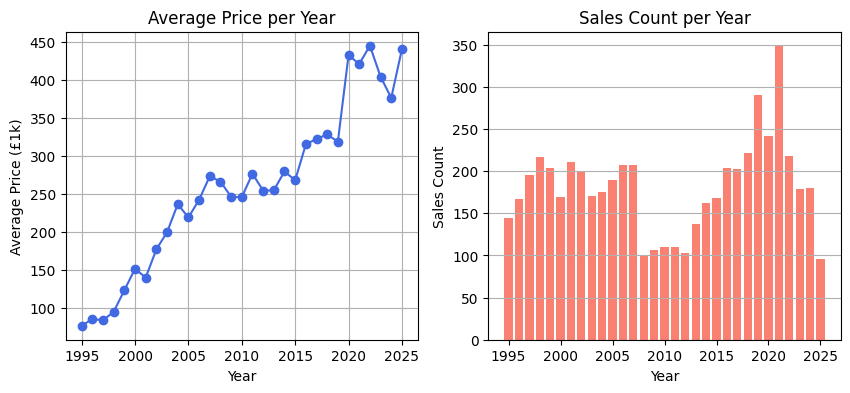

In [9]:
import matplotlib.pyplot as plt
import duckdb
import pandas as pd

con = duckdb.connect("../data/main.db")

result_df = con.sql("""
    SELECT 
        year(deed_date) as year,
        AVG(price_paid) as avg_price,
        COUNT(*) as sales_count
    FROM transactions
    GROUP BY year
    ORDER BY year
""").df()
result_df["date"] = pd.to_datetime(result_df['year'].astype(str) + '-01-01')

display(result_df.sample(5))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result_df["year"], result_df["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].bar(result_df["year"], result_df["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")


In [10]:
# con = duckdb.connect("../data/main.db")

# result_df = con.sql("""
#     SELECT 
#         strftime(deed_date, '%Y-%m') AS year_month,
#         AVG(price_paid) as avg_price,
#         COUNT(*) as sales_count
#     FROM transactions
#     GROUP BY year_month
#     ORDER BY year_month
# """).df()

# result_df["date"] = pd.to_datetime(result_df['year_month'] + '-01')
# display(result_df.sample(5))

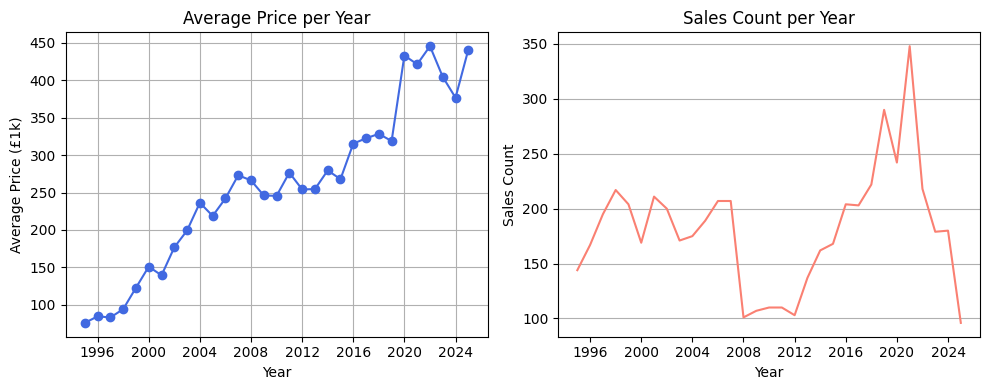

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result_df["date"], result_df["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].plot(result_df["date"], result_df["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")

plt.tight_layout()
plt.show()

## Interest rates


In [12]:
df_interest = pd.read_csv("../data/interest_rates.csv")

df_interest["change_date"] = pd.to_datetime(df_interest["Date Changed"], format="%d %b %y")
df_interest = df_interest.rename(columns={"Rate": "rate"}).drop("Date Changed", axis=1)
df_interest = df_interest.sort_values('change_date')
display(df_interest.head(2))

,rate,change_date
257,11.25,1975-01-20
256,11.00,1975-01-27


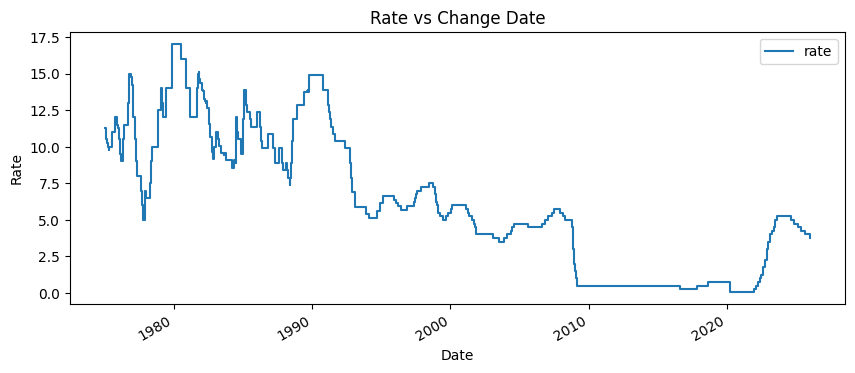

In [13]:
import matplotlib.pyplot as plt

df_interest.plot(x='change_date', y='rate', drawstyle='steps-post', figsize=(10, 4))
plt.title('Rate vs Change Date')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.show()


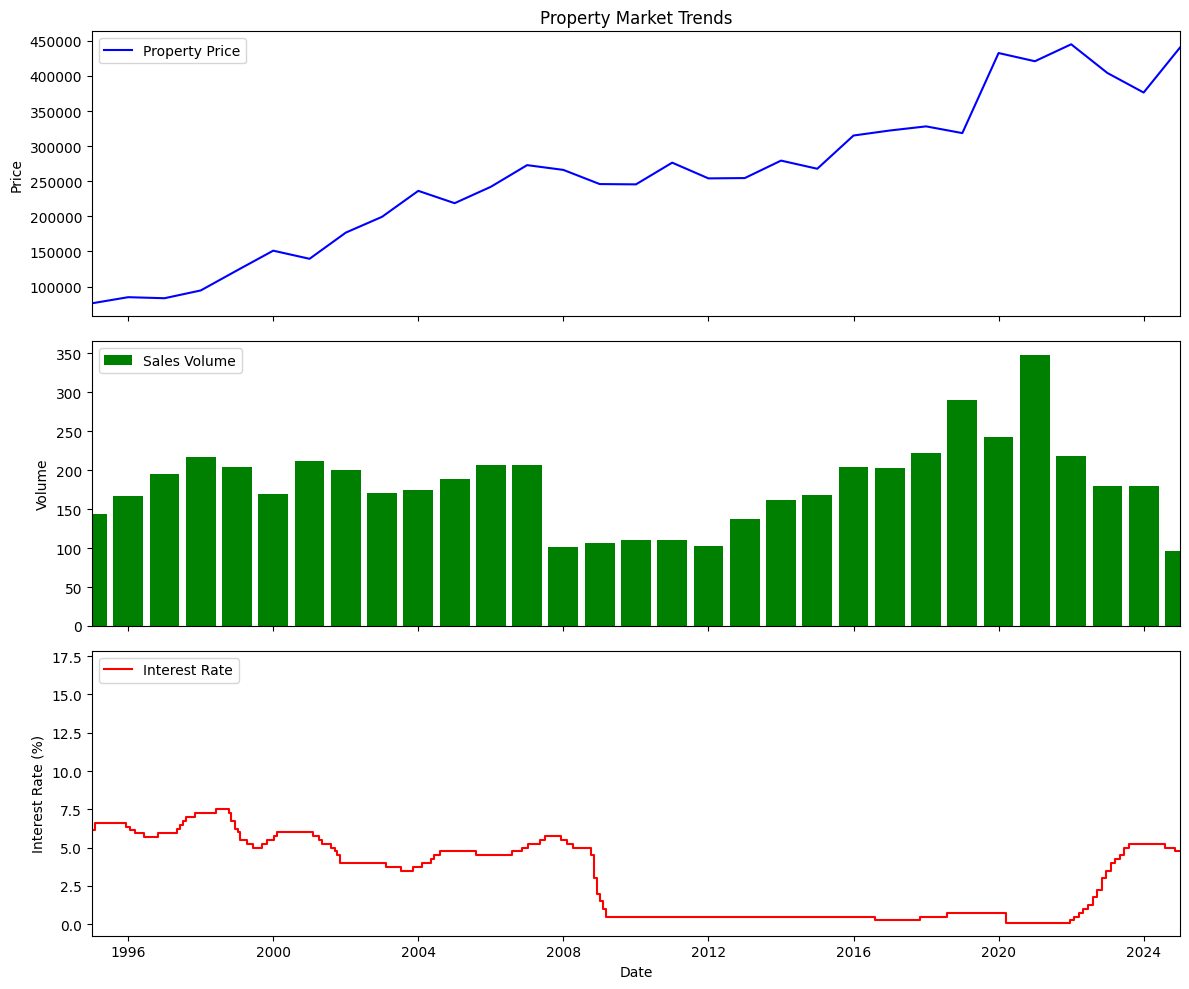

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

# Plot Property Prices
ax1.plot(result_df['date'], result_df['avg_price'], color='blue', label='Property Price')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.set_title('Property Market Trends')

# Plot Sales Volume
ax2.bar(result_df['date'], result_df['sales_count'], color='green', label='Sales Volume', width=300)
ax2.set_ylabel('Volume')
ax2.legend(loc='upper left')

# Plot Interest Rate
ax3.plot(df_interest['change_date'], df_interest['rate'], color='red', label='Interest Rate', drawstyle='steps-post')
ax3.set_ylabel('Interest Rate (%)')
ax3.set_xlabel('Date')
ax3.legend(loc='upper left')

plt.xlim(result_df['date'].min(), result_df['date'].max())

plt.tight_layout()

## Number of transactions per property

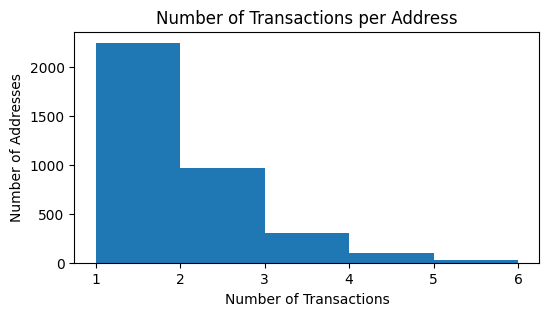

In [26]:
import matplotlib.pyplot as plt
import duckdb
import pandas as pd

con = duckdb.connect("../data/main.db")

result_df = con.sql("""
    SELECT 
        address,
        COUNT(*) as num_transactions
    FROM transactions
    GROUP BY address
    ORDER BY num_transactions DESC
""").df()

result_df.head()
max_value = result_df['num_transactions'].max()
plt.figure(figsize=(6, 3))
plt.hist(result_df['num_transactions'], bins=max_value-1)
plt.title('Number of Transactions per Address')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Addresses')
plt.show()

In [35]:

result_df = con.sql("""
    SELECT * 
    FROM transactions
    WHERE address IN (
        SELECT address 
        FROM transactions
        GROUP BY address
        HAVING COUNT(*) > 1
    )
    ORDER BY address, deed_date
""").df()

print(result_df.shape)
result_df.head()

(3385, 9)


,id,address,deed_date,price_paid,property_type,estate_type,new_build,transaction_category,unique_id
0,1079,1 ENGLEFIELD TERRACE;CHURCH STREET;KEINTON MAN...,2014-12-05,222000,T,F,N,A,4F7D4307-49E6-462B-9F4D-6D22C0122187
1,1078,1 ENGLEFIELD TERRACE;CHURCH STREET;KEINTON MAN...,2019-10-01,297000,T,F,N,A,965B6D91-E34B-95E4-E053-6C04A8C07729
2,3754,100;BEHIND BERRY;SOMERTON;SOMERTON;TA11 6SF,1995-06-30,57000,S,F,N,A,98030A36-A249-49F3-B2F7-3A2FC7A2A15B
3,3753,100;BEHIND BERRY;SOMERTON;SOMERTON;TA11 6SF,2005-09-02,185000,S,F,N,A,40015B51-AC3E-4C15-9DBE-1B0B4A6693C7
4,3752,100;BEHIND BERRY;SOMERTON;SOMERTON;TA11 6SF,2007-12-18,225000,S,F,N,A,06B33085-5921-461F-875E-BA9ED0A33E45


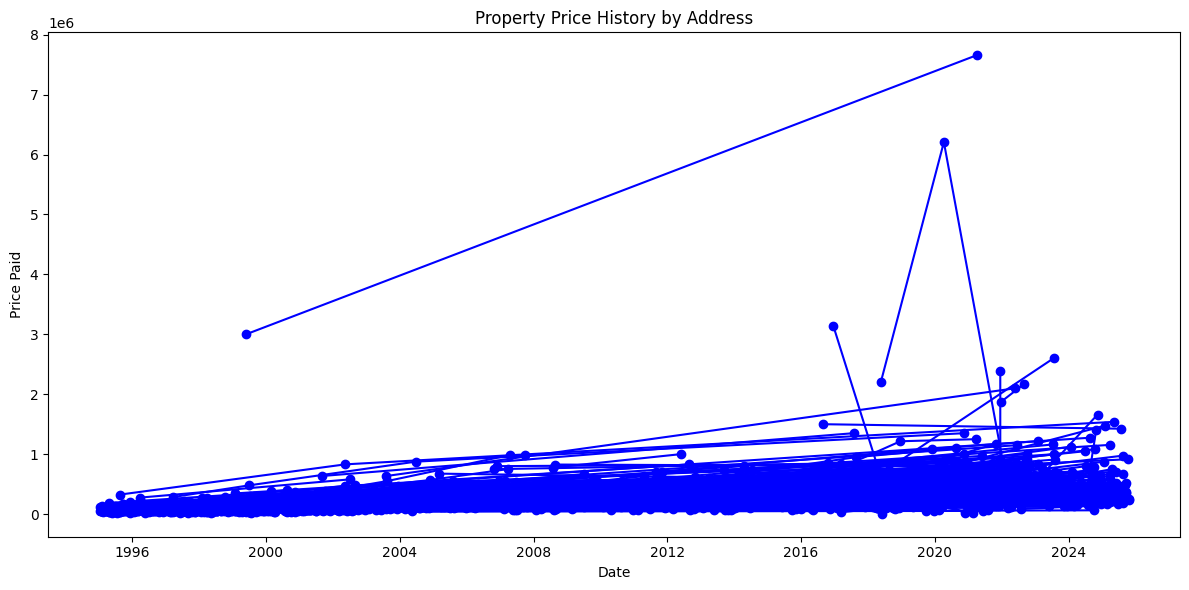

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for address, group in result_df.groupby('address'):
    group = group.sort_values('deed_date')
    ax.plot(group['deed_date'], group['price_paid'], marker='o', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price Paid')
ax.set_title('Property Price History by Address')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [32]:

result_df = con.sql("""
    SELECT  
        year(deed_date) as year,
        AVG(price_paid) as avg_price,
        COUNT(*) as sales_count
    FROM transactions
    WHERE address IN (
        SELECT address 
        FROM transactions
        GROUP BY address
        HAVING COUNT(*) > 1
    )
    GROUP BY year
    ORDER BY year
""").df()

print(result_df.shape)
result_df.head()


(31, 3)


,year,avg_price,sales_count
0,1995,74970.678161,87
1,1996,85575.481481,108
2,1997,84383.582677,127
3,1998,90887.642276,123
4,1999,132133.629630,135


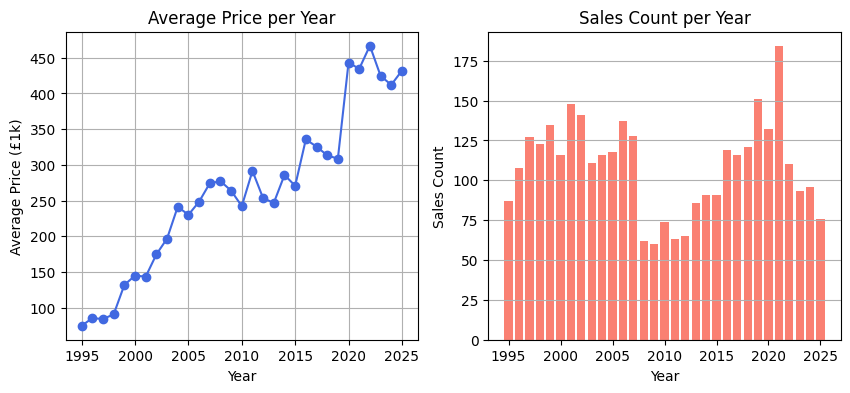

In [33]:

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result_df["year"], result_df["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].bar(result_df["year"], result_df["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")
